In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv("data/time_domain_features_holter.csv")
y = df["died"].values
X = df.drop(["ID", "died"], axis=1).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
X.shape

(176, 64)

## Utils


In [3]:
from importlib import reload
import utils

reload(utils)

from utils import (
    preprocess,
    find_best_fold,
    calculate_metrics,
    plot_confusion_matrix,
    display_kfold_scores,
    apply_grid_search,
    extract_params_and_k,
    get_kfold_results,
)


from geometric_mean_score import gmean_scorer
from corr_feature_reducer import CorrelationFeatureReducer
from sklearn.decomposition import PCA

## Constants


In [4]:
MODEL_PREFIX = "clf"
K_KEY = "select__n_components"
REDUCTION_TYPE = "pca"

SELECTOR_MAP = {
    "kbest": SelectKBest(f_classif),
    "corr": CorrelationFeatureReducer(),
    "pca": PCA(),
}

SELECTOR = SELECTOR_MAP[REDUCTION_TYPE]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Logistic Regression


In [ ]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("select", SELECTOR),
        ("clf", LogisticRegression(solver="liblinear", max_iter=1000, random_state=42)),
    ]
)

param_grid = {
    "select__n_components": [10, 20, 30, 40, 50, X.shape[-1]],
    "clf__penalty": ["l1", "l2"],
    "clf__C": [0.001, 0.01, 0.1, 1, 10],
    "clf__class_weight": [None, "balanced"],
}

params = apply_grid_search(
    X_train, y_train, estimator=pipeline, param_grid=param_grid, scoring="f1"
)

best_params, best_k = extract_params_and_k(params, MODEL_PREFIX, K_KEY)

print(f"Best params: {best_params}")
print(f"Best k: {best_k}")

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best score: 0.7605105776734999
Best params: {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'}
Best k: 20


In [6]:
X_train_, X_test_ = preprocess(
    X_train, X_test, y_train, k=best_k, reduction_type=REDUCTION_TYPE
)


model = LogisticRegression(
    solver="liblinear", max_iter=1000, random_state=42, **best_params
)
model.fit(X_train_, y_train)


y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test, y_pred, display=True)

Accuracy: 75.00
Precision: 61.54
Recall: 66.67
Specificity: 79.17
F1 Score: 64.00
Geometric Mean: 72.65


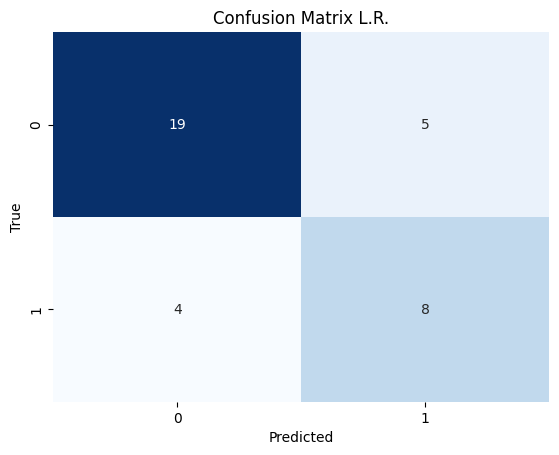

In [7]:
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix L.R.")

In [8]:
metrics = get_kfold_results(
    model=LogisticRegression(
        solver="liblinear", max_iter=1000, random_state=42, **best_params
    ),
    X=X_train,
    y=y_train,
    cv=cv,
    best_k=best_k,
    preprocess_reduction_type=REDUCTION_TYPE,
)

display_kfold_scores(metrics)

K-Fold Results
Accuracy: 77.14 ± 5.35
Precision: 65.24 ± 11.01
Recall: 76.44 ± 16.20
Specificity: 77.43 ± 9.61
F1 Score: 68.75 ± 7.39
Geometric Mean: 76.05 ± 6.20


In [ ]:
best_fold, idx_best_fold = find_best_fold(
    cv.split(X_train, y_train), metrics, eval_metric="f1"
)
print(f"Best fold: {idx_best_fold + 1}")

train_idx, test_idx = best_fold
X_train_ = X_train[train_idx]
X_test_ = X_train[test_idx]
y_train_ = y_train[train_idx]
y_test_ = y_train[test_idx]

X_train_, X_test_ = preprocess(
    X_train_, X_test_, y_train_, k=best_k, reduction_type=REDUCTION_TYPE
)
model = LogisticRegression(
    solver="liblinear", max_iter=1000, random_state=42, **best_params
)
model.fit(X_train_, y_train_)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test_, y_pred, display=True)

Best fold: 5
Accuracy: 82.14
Precision: 69.23
Recall: 90.00
Specificity: 77.78
F1 Score: 78.26
Geometric Mean: 83.67


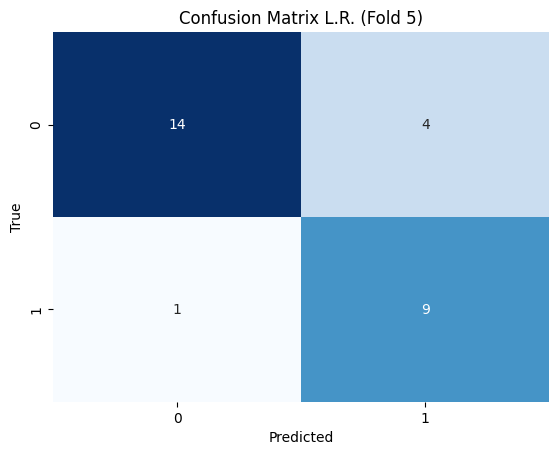

In [10]:
plot_confusion_matrix(
    y_test_, y_pred, title=f"Confusion Matrix L.R. (Fold {idx_best_fold + 1})"
)

## SVC


In [ ]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("select", SELECTOR),
        ("clf", SVC(random_state=42)),
    ]
)

param_grid = {
    "select__n_components": [10, 20, 30, 40, 50, X.shape[-1]],
    "clf__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "clf__gamma": ["scale", "auto"],
    "clf__class_weight": [None, "balanced"],
}

params = apply_grid_search(
    X_train, y_train, estimator=pipeline, param_grid=param_grid, scoring="f1"
)

best_params, best_k = extract_params_and_k(params, MODEL_PREFIX, K_KEY)

print(f"Best params: {best_params}")
print(f"Best k: {best_k}")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best score: 0.7795921884763329
Best params: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
Best k: 20


In [12]:
X_train_, X_test_ = preprocess(
    X_train, X_test, y_train, k=best_k, reduction_type=REDUCTION_TYPE
)


model = SVC(random_state=42, **best_params)


model.fit(X_train_, y_train)


y_pred = model.predict(X_test_)


_ = calculate_metrics(y_test, y_pred, display=True)

Accuracy: 75.00
Precision: 58.82
Recall: 83.33
Specificity: 70.83
F1 Score: 68.97
Geometric Mean: 76.83


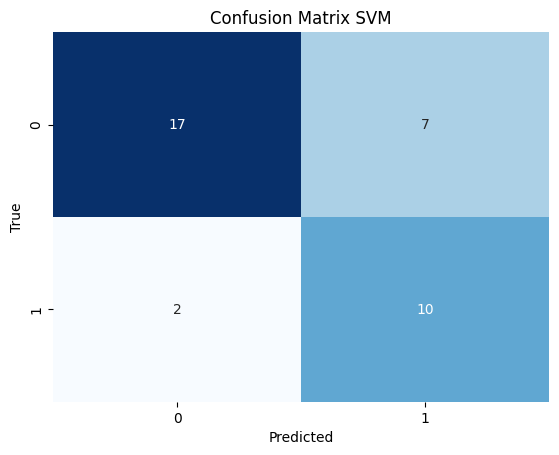

In [13]:
plot_confusion_matrix(y_test, y_pred, title="Confusion Matrix SVM")

In [14]:
metrics = get_kfold_results(
    model=SVC(random_state=42, **best_params),
    X=X_train,
    y=y_train,
    cv=cv,
    best_k=best_k,
    preprocess_reduction_type=REDUCTION_TYPE,
)

display_kfold_scores(metrics)

K-Fold Results
Accuracy: 76.43 ± 8.63
Precision: 63.16 ± 13.67
Recall: 87.33 ± 11.96
Specificity: 70.99 ± 13.89
F1 Score: 71.91 ± 8.37
Geometric Mean: 77.96 ± 7.10


In [ ]:
best_fold, idx_best_fold = find_best_fold(
    cv.split(X_train, y_train), metrics, eval_metric="f1"
)
print(f"Best fold: {idx_best_fold + 1}")

train_idx, test_idx = best_fold
X_train_ = X_train[train_idx]
X_test_ = X_train[test_idx]
y_train_ = y_train[train_idx]
y_test_ = y_train[test_idx]

X_train_, X_test_ = preprocess(
    X_train_, X_test_, y_train_, k=best_k, reduction_type=REDUCTION_TYPE
)
model = SVC(random_state=42, **best_params)
model.fit(X_train_, y_train_)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test_, y_pred, display=True)

Best fold: 3
Accuracy: 89.29
Precision: 87.50
Recall: 77.78
Specificity: 94.74
F1 Score: 82.35
Geometric Mean: 85.84


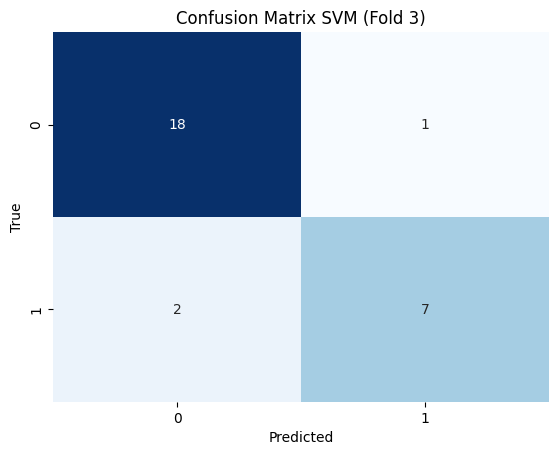

In [16]:
plot_confusion_matrix(
    y_test_, y_pred, title=f"Confusion Matrix SVM (Fold {idx_best_fold + 1})"
)

## KNN


In [ ]:
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("select", SELECTOR),
        ("clf", KNeighborsClassifier()),
    ]
)

param_grid = {
    "select__n_components": [10, 20, 30, 40, 50, X.shape[-1]],
    "clf__n_neighbors": [3, 5, 7, 9, 11, 13],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2, 3],
}

params = apply_grid_search(
    X_train, y_train, estimator=pipeline, param_grid=param_grid, scoring="f1"
)

best_params, best_k = extract_params_and_k(params, MODEL_PREFIX, K_KEY)

print(f"Best params: {best_params}")
print(f"Best k: {best_k}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best score: 0.5438603653544484
Best params: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best k: 30


In [18]:
X_train_, X_test_ = preprocess(
    X_train, X_test, y_train, k=best_k, reduction_type=REDUCTION_TYPE
)


model = KNeighborsClassifier(**best_params)

model.fit(X_train_, y_train)


y_pred = model.predict(X_test_)

_ = calculate_metrics(y_test, y_pred, display=True)

Accuracy: 75.00
Precision: 63.64
Recall: 58.33
Specificity: 83.33
F1 Score: 60.87
Geometric Mean: 69.72


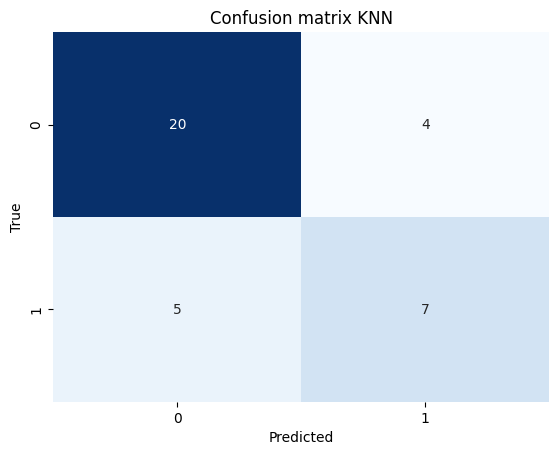

In [19]:
plot_confusion_matrix(y_test, y_pred, "Confusion matrix KNN")

In [20]:
metrics = get_kfold_results(
    model=KNeighborsClassifier(**best_params),
    X=X_train,
    y=y_train,
    cv=cv,
    best_k=best_k,
    preprocess_reduction_type=REDUCTION_TYPE,
)

display_kfold_scores(metrics)

K-Fold Results
Accuracy: 64.29 ± 6.78
Precision: 45.74 ± 13.37
Recall: 39.78 ± 13.45
Specificity: 76.43 ± 6.90
F1 Score: 42.26 ± 13.20
Geometric Mean: 54.39 ± 10.35


In [ ]:
best_fold, idx_best_fold = find_best_fold(
    cv.split(X_train, y_train), metrics, eval_metric="f1"
)
print(f"Best fold: {idx_best_fold + 1}")

train_idx, test_idx = best_fold
X_train_ = X_train[train_idx]
X_test_ = X_train[test_idx]
y_train_ = y_train[train_idx]
y_test_ = y_train[test_idx]

X_train_, X_test_ = preprocess(
    X_train_, X_test_, y_train_, k=best_k, reduction_type=REDUCTION_TYPE
)
model = KNeighborsClassifier(**best_params)
model.fit(X_train_, y_train_)

y_pred = model.predict(X_test_)
_ = calculate_metrics(y_test_, y_pred, display=True)

Best fold: 4
Accuracy: 71.43
Precision: 60.00
Recall: 60.00
Specificity: 77.78
F1 Score: 60.00
Geometric Mean: 68.31


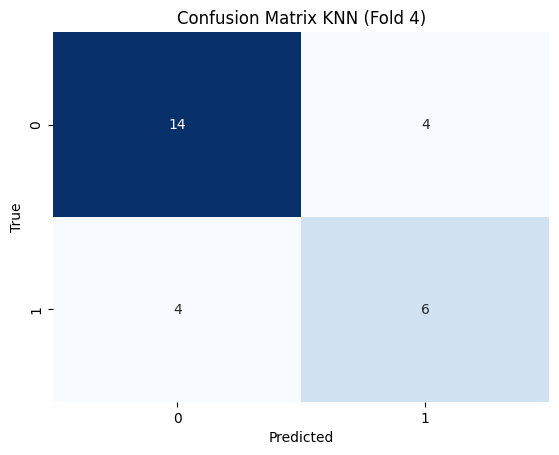

In [22]:
plot_confusion_matrix(
    y_test_, y_pred, title=f"Confusion Matrix KNN (Fold {idx_best_fold + 1})"
)